# Spectral fitting example

**To run this, you need FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip in cosipy/cosipy/test_data. To fit the megalib simulation, you need grb_bkg_binned_data.hdf5, grb_binned_data.hdf5, & bkg_binned_data.hdf5 in cosipy/docs/tutorials/data, and to fit the source injector data, you need GRBdata.h5, GRBsignal.h5, and GRBbkg.h5 in cosipy/docs/tutorials/data.**

The goal of this notebook is to get familiar with 3ML and get a concrete idea on the spectral fitting will work. 

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple dataset form different instruments to be used coherently to fit the parameters of source model. A source model typically consists on a list of sources with a parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the _expected_ counts, given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed. Finally, we will fit a power law:

$$
F(E) = K \left(\frac{E}{E_{piv}}\right)^{-index}
$$


where $K$ (normalization) and the spectral index are the only free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = b_i + s_i(\mathbf{x}) = b_i + s_i(\mathrm{norm}, \mathrm{index})
$$

where $b_i$ are the estimated counts due to background on each bin, and $s_i$ are the corresponding expected counts from the source.

The goal is then to find the values of $\mathbf{x} = [\mathrm{norm}, \mathrm{index}]$ that maximize $\mathcal{L}$. These are the best estimation of the parameters.

The final module needs to also fit the background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, test_data, BinnedData
from cosipy.coordinates.orientation import Orientation_file
from scoords import SpacecraftFrame, Attitude

from histpy import Histogram

from astropy.time import Time
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt

from threeML import Powerlaw, Band, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

15:02:03 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=129337;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=370719;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=418109;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=994287;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=607038;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=487143;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=213928;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=164428;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=709953;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=822174;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=297311;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=5798;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=440923;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=53019;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=418341;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=258308;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

15:02:03 INFO      Starting 3ML!                                                                     ]8;id=928791;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=71034;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=913661;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=82844;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=878513;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=118095;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=433760;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=893617;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=770408;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=493959;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=477378;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=495599;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=223399;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=656986;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

15:02:04 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=365860;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=277659;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=519089;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=703529;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=754240;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=565663;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

15:02:04 WARNING   No fermitools installed                                              ]8;id=825604;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=611059;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=241674;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=55756;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=288989;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=993511;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=271266;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=580634;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Read in data (megalib simulation)

Read in the spacecraft orientation file & select times for GRB

In [5]:
ori = Orientation_file.parse_from_file("data/20280301_first_2hrs.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only

In [21]:
crab = BinnedData("data/crab.yaml")
crab_bkg = BinnedData("data/background.yaml")
bkg = BinnedData("data/background.yaml")

Read in .tra files for the Crab & background. This does not need to be done if you already have .hdf5 files

In [19]:
# crab.read_tra(output_name="data/crab_unbinned_data")
# bkg.read_tra(output_name="data/bkg_unbinned_data")

Combine unbinned Crab & background .hdf5 files. This does not need to be done if you already have a combined .hdf5 file

In [43]:
# full.combine_unbinned_data(["data/grb_unbinned_data.hdf5","data/crab_unbinned_data.hdf5","data/bkg_unbinned_data.hdf5"], output_name="data/full_unbinned_data")


adding data/grb_unbinned_data.hdf5...


adding data/crab_unbinned_data.hdf5...


adding data/bkg_unbinned_data.hdf5...



In [99]:
# full_grb.select_data(unbinned_data="data/full_unbinned_data.hdf5", output_name="data/full_selected_unbinned_data")

Making data selections...


Bin Crab only, Crab+background, and background only files. This does not need to be done if you already have binned .hdf5 files

binning data...

Note: time bins must be equally spaced between min and max time.
Using time bin size [s]: 0.5


PsiChi binning:
Approximate resolution at NSIDE 8 is 7.3 deg



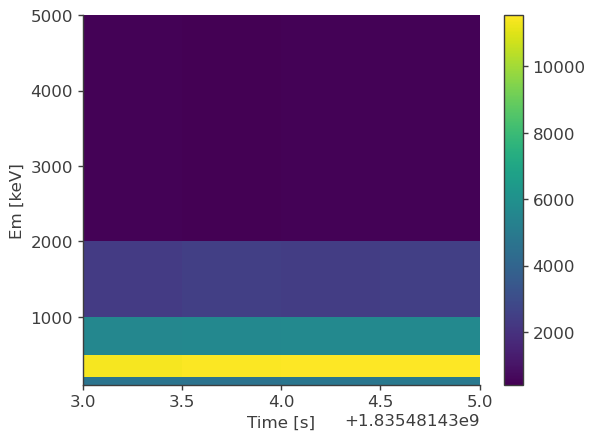

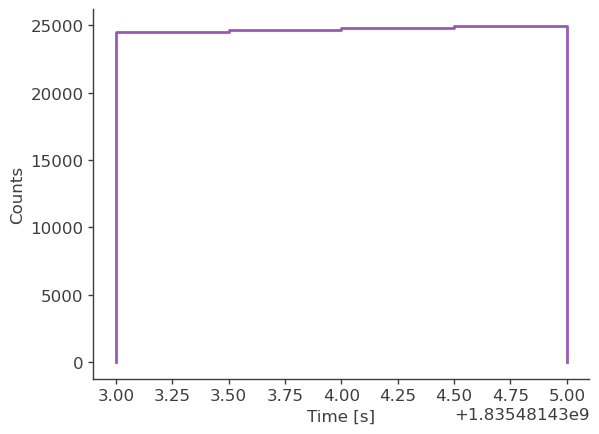

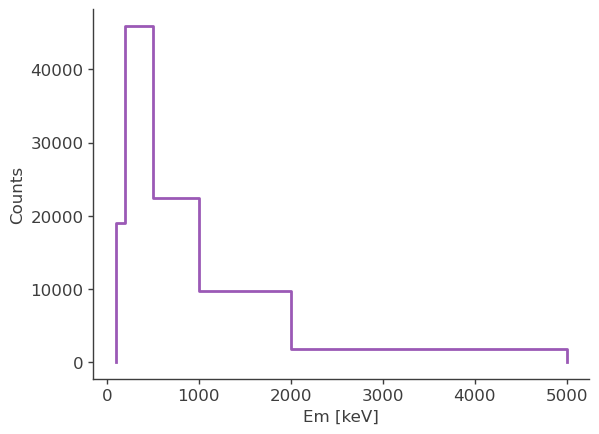

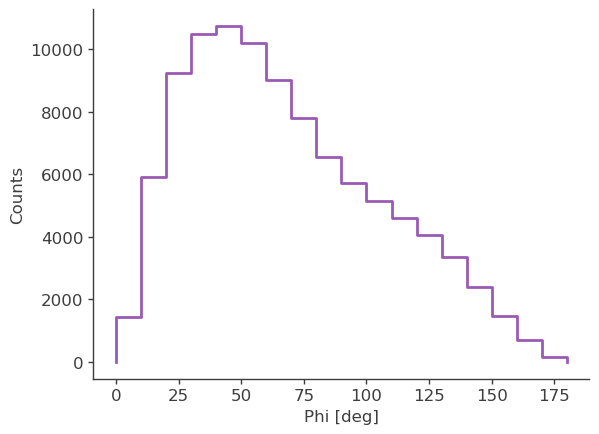

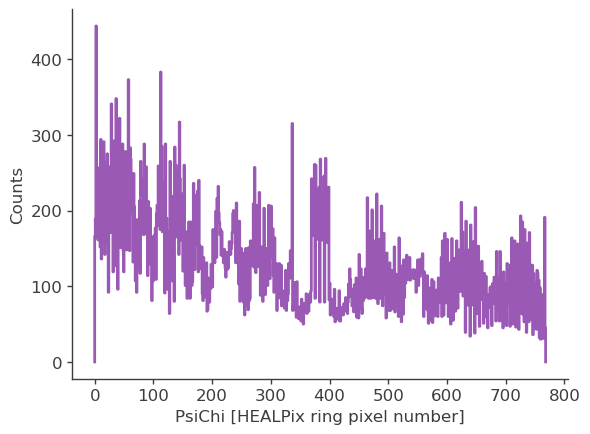

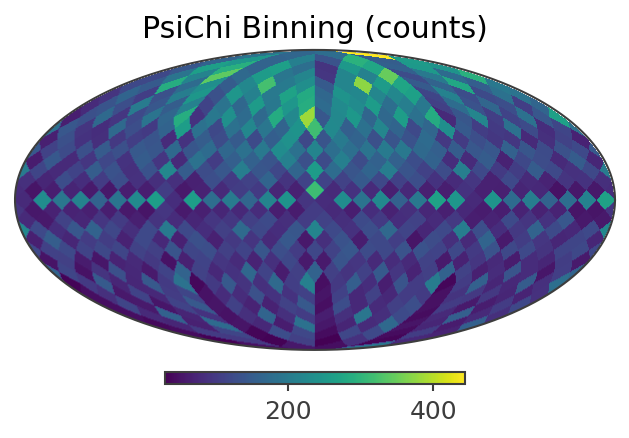

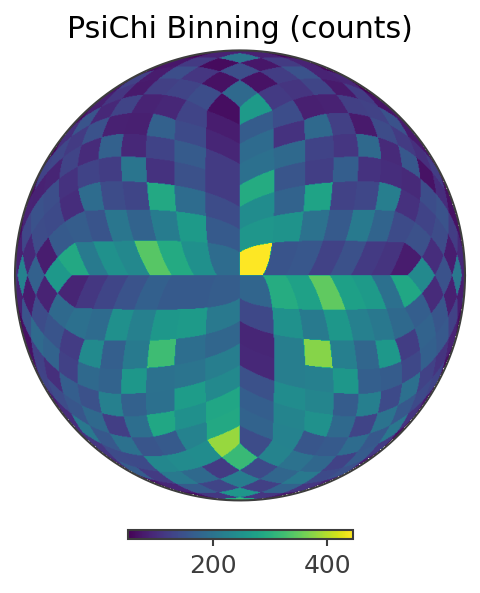

In [101]:
# grb.get_binned_data(unbinned_data="data/grb_unbinned_data.hdf5", make_binning_plots=True, output_name="data/grb_binned_data")
# crab.get_binned_data(unbinned_data="data/crab_unbinned_data.hdf5", make_binning_plots=True, output_name="data/crab_binned_data")
# crab_bkg.get_binned_data(unbinned_data="data/crab_bkg_unbinned_data.hdf5", make_binning_plots=True, output_name="data/crab_bkg_binned_data_grbtime")
# bkg.get_binned_data(unbinned_data="data/bkg_unbinned_data.hdf5", make_binning_plots=True, output_name="data/bkg_binned_data")
# full.get_binned_data(unbinned_data="data/full_unbinned_data.hdf5", make_binning_plots=True, output_name="data/full_binned_data")
# full_grb.get_binned_data(unbinned_data="data/full_selected_unbinned_data.hdf5", make_binning_plots=True, output_name="data/full_selected_binned_data")

Create spectra and lightcurves for Crab only, Crab+background, and background only

getting raw spectrum...


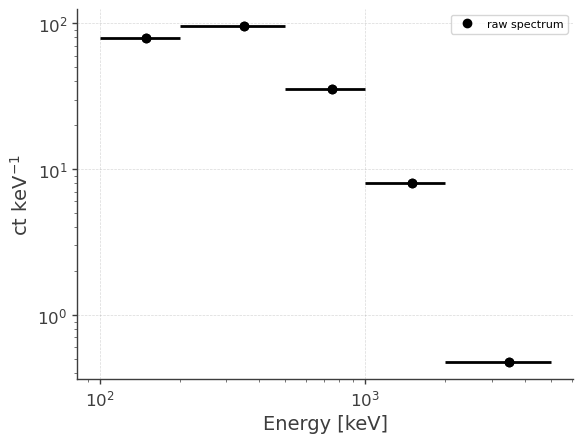

getting raw lightcurve...


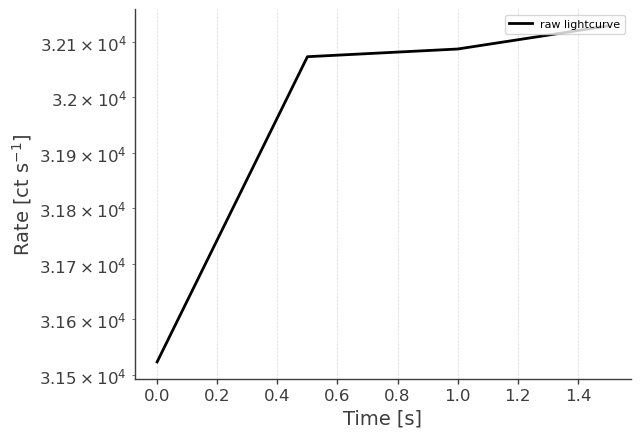

getting raw spectrum...


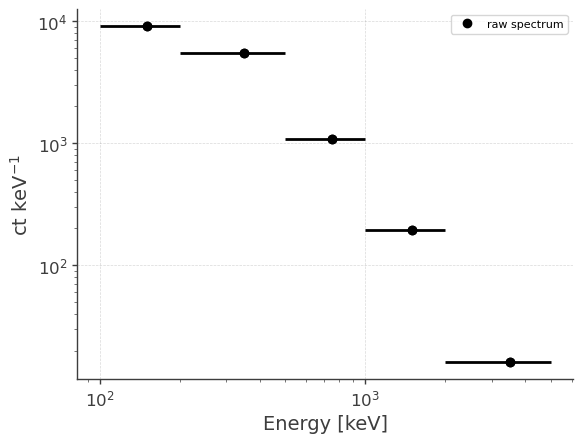

getting raw lightcurve...


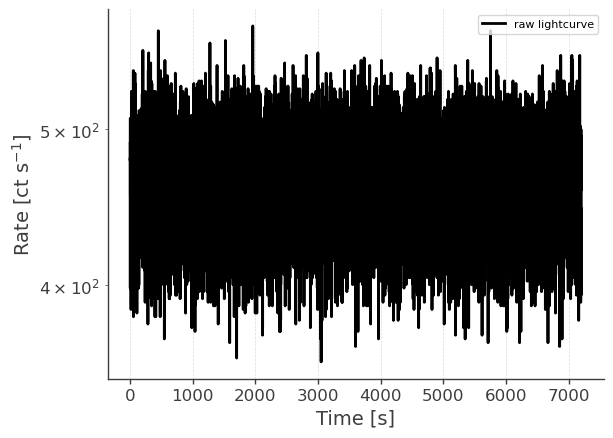

getting raw spectrum...


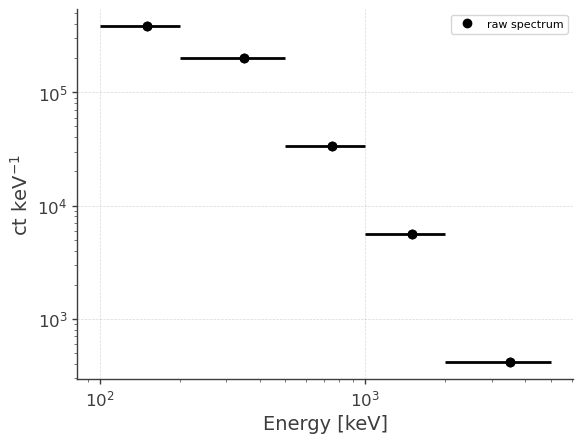

getting raw lightcurve...


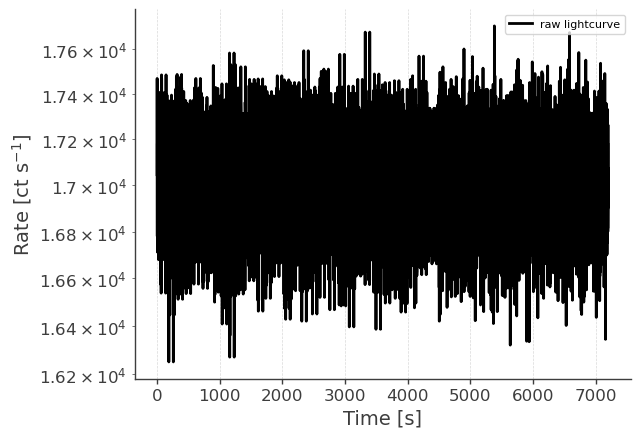

getting raw spectrum...


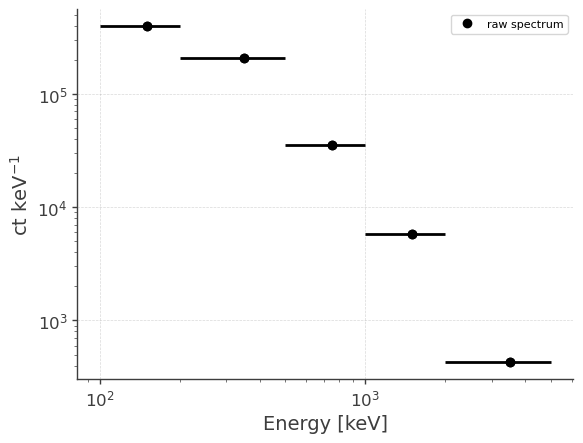

getting raw lightcurve...


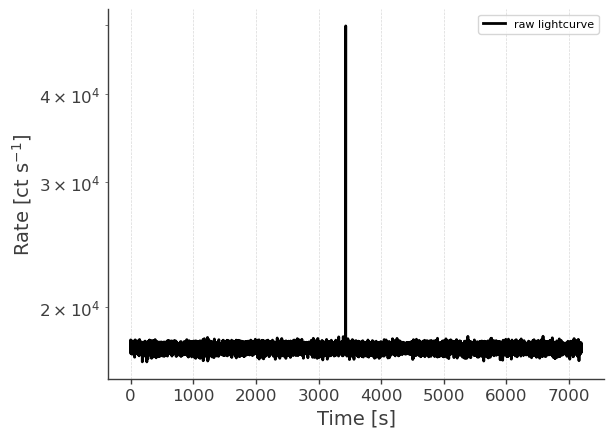

In [45]:
#crab.get_raw_spectrum(binned_data="data/crab_binned_data.hdf5", output_name="data/crab_sp")
#crab.get_raw_lightcurve(binned_data="data/crab_binned_data.hdf5", output_name="data/crab_lc")
#crab_bkg.get_raw_spectrum(binned_data="data/crab_bkg_binned_data.hdf5", output_name="data/crab_bkg_sp")
#crab_bkg.get_raw_lightcurve(binned_data="data/crab_bkg_binned_data.hdf5", output_name="data/crab_bkg_lc")
#bkg.get_raw_spectrum(binned_data="data/bkg_binned_data.hdf5", output_name="data/bkg_sp")
#bkg.get_raw_lightcurve(binned_data="data/bkg_binned_data.hdf5", output_name="data/bkg_lc")

Load binned .hdf5 files if you already have them

In [22]:
crab.load_binned_data_from_hdf5(binned_data="data/crab_binned_data.hdf5")
crab_bkg.load_binned_data_from_hdf5(binned_data="data/crab_bkg_binned_data_grbtime.hdf5")
bkg.load_binned_data_from_hdf5(binned_data="data/bkg_binned_data.hdf5")

## Perform spectral fit (megalib simulation)

Define inputs needed by COSI plugin, optionally set background parameter (fits amplitude of background), and instantiate threeML plugin

In [23]:
dr = test_data.path / "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5" # path to detector response

bkg_par = Parameter("background_cosi",                                        # background parameter
                    1,                                                        # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = dr,                                                      # detector response
                data = crab_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data 
                bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                sc_orientation = ori,                                         # spacecraft orientation
                nuisance_param = bkg_par)                                     # background parameter

In [24]:
index = -2.32
piv = 500 * u.keV
K = 1.56e-5 / u.cm / u.cm / u.s / u.keV

spectrum_crab = Powerlaw(index=index,
                         piv=piv.value,
                         K=K.value)

spectrum_crab.K.unit = K.unit
spectrum_crab.piv.unit = piv.unit

source_crab = PointSource("crab",                     # Name of source (arbitrary, but needs to be unique)
                   l = 184.56,                        # Longitude (deg)
                   b = -5.78,                         # Latitude (deg)
                   spectral_shape = spectrum_crab)    # Spectral model

crab_model = Model(source_crab)

In [25]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

crab_like = JointLikelihood(crab_model, plugins, verbose = False)

crab_like.fit()

15:16:09 INFO      set the minimizer to minuit                                             ]8;id=894723;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371573;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log



15:16:22 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=264902;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=358368;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Powerlaw.K,(6.52 +/- 0.08) x 10^-6,1 / (cm2 keV s)
crab.spectrum.main.Powerlaw.index,-1.856 +/- 0.008,
background_cosi,1.01642 +/- 0.00017,


Correlation matrix:

1.00,-0.34,-0.83
-0.34,1.00,0.41
-0.83,0.41,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-9.308026e+08
total,-9.308026e+08


Values of statistical measures:

,statistical measures
AIC,-1.861605e+09
BIC,-1.861605e+09


(                                      value  negative_error  positive_error  \
 crab.spectrum.main.Powerlaw.K      0.000007   -8.235960e-08    8.159161e-08   
 crab.spectrum.main.Powerlaw.index -1.855859   -8.315810e-03    8.548558e-03   
 background_cosi                    1.016423   -1.704133e-04    1.725321e-04   
 
                                           error             unit  
 crab.spectrum.main.Powerlaw.K      8.197560e-08  1 / (cm2 keV s)  
 crab.spectrum.main.Powerlaw.index  8.432184e-03                   
 background_cosi                    1.714727e-04                   ,
        -log(likelihood)
 cosi      -9.308026e+08
 total     -9.308026e+08)

## 3ML error propagation and plotting (megalib simulation)

Define injected spectral parameters 

In [26]:
K_inj = 7.559e-4       # 1/keV/cm2/s
piv_inj = 100.         # keV
alpha_inj = -1.99
beta_inj = -2.32
xp_inj = 5.31          # keV 

The summary of the results above tell you the optimal values of the parameters, as well as the errors. You typically want to propagate these into the error in the flux at different energies, and plot the spectrum. Let's do that:

Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Powerlaw.K,(6.52 +/- 0.08) x 10^-6,1 / (cm2 keV s)
crab.spectrum.main.Powerlaw.index,-1.856 +/- 0.008,
background_cosi,1.01642 +/- 0.00017,


Correlation matrix:

1.00,-0.34,-0.83
-0.34,1.00,0.41
-0.83,0.41,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-9.308026e+08
total,-9.308026e+08


Values of statistical measures:

,statistical measures
AIC,-1.861605e+09
BIC,-1.861605e+09


None
  * crab (point source):
    * position:
      * l:
        * value: 184.56
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -5.78
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 6.521699447196916e-06
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 500.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -1.8558591950788657
    

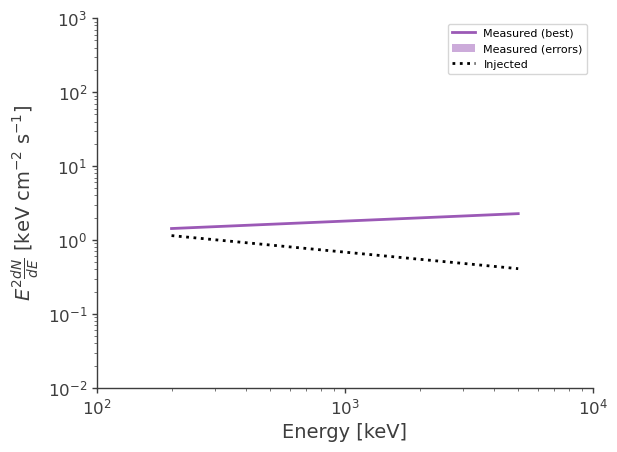

In [27]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = crab_like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["crab"].parameters.values()
              if par.free}

if 'l' in parameters:
    del parameters['l']
if 'b' in parameters:
    del parameters['b']

results_err = results.propagate(results.optimized_model["crab"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["crab"])

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

# Plot injected spectrum
def band_chris(energy, alpha, beta, E0):
    ebreak = (alpha - beta) * E0
    if energy < ebreak:
        return (energy/100.)**alpha * np.exp(-energy/E0)
    else:
        return (ebreak/100.)**(alpha-beta) * np.exp(beta-alpha) * (energy/100.)**beta

flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux_inj[i] = K_inj * band_chris(e, alpha_inj, beta_inj, xp_inj)
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(1e-2, 1e3)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend()